In [1]:
#import things
# import Libraries
# Built-in Python libraries
import os # functions for interacting w operating system

# 3rd-party libraries
import numpy as np # module for low-level scientific computing
import pymc3 as pm
import theano.tensor as tt
import pickle
import pylab as plt
from scipy import stats

import csv
import pandas as pd

Text(0, 0.5, 'Exp')

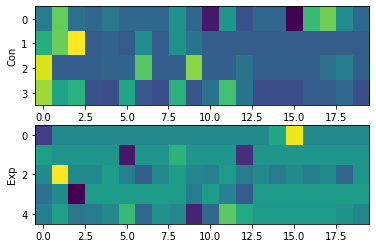

In [2]:
#Get name of directory where the data files and pickle file sits, and change to that directory for processing
dir_name = '/media/fastdata/brad_changepoint'
os.chdir(dir_name)

con_name = 'con_zscoreddiff_rearingduration.csv'
con_df = pd.read_csv(con_name,header=None)
con_data_mat = con_df.to_numpy()

exp_name = 'exp_zscoreddiff_rearingduration.csv'
exp_df = pd.read_csv(exp_name,header=None)
exp_data_mat = exp_df.to_numpy()


n_count_data = con_data_mat.shape[-1]
fig,ax = plt.subplots(2,1)
ax[0].imshow(con_data_mat,aspect='auto')
ax[0].set_ylabel('Con')
ax[1].imshow(exp_data_mat,aspect='auto')
ax[1].set_ylabel('Exp')

## Test Data

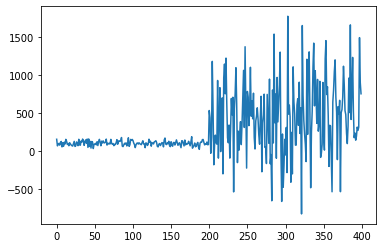

In [8]:
# Test data
length = 200
mu1 = 100
mu2 = 500
sigma1 = 30
sigma2 = 500

test_data = np.concatenate((stats.norm.rvs(mu1,sigma1,length),stats.norm.rvs(mu2,sigma2,length)))
plt.plot(test_data);


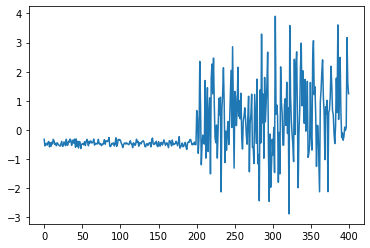

In [11]:
zscore_test_data = stats.zscore(test_data,axis=-1)
plt.plot(zscore_test_data)

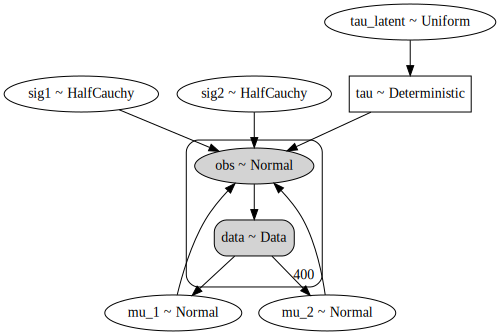

In [19]:
with pm.Model() as model:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", zscore_test_data)
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma1 = pm.HalfCauchy('sig1', 1)
    sigma2 = pm.HalfCauchy('sig2', 1)

    idx = np.arange(len(test_data)) # Index
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2
    sigma_ = (1 - weight) * sigma1 + weight * sigma2


with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=data)

pm.model_to_graphviz(model)

In [20]:
with model:
        # Switch out the observed dataset
        pm.set_data({"data": test_data})
        test_trace = pm.sample(step = pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4091.58draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


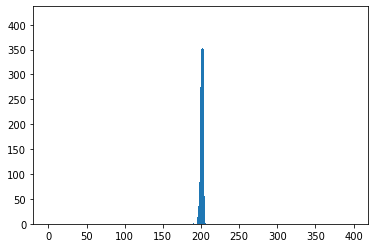

In [21]:
plt.hist(test_trace['tau'],np.arange(0,2*length));

## Actual Data

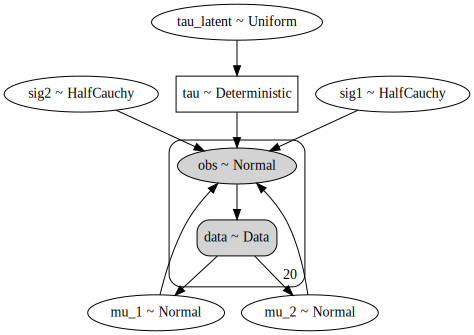

In [87]:
with pm.Model() as model:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", con_data_mat[0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma1 = pm.HalfCauchy('sig1', 1)
    sigma2 = pm.HalfCauchy('sig2', 1)

    idx = np.arange(n_count_data) # Index
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2
    sigma_ = (1 - weight) * sigma1 + weight * sigma2


with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=data)

pm.model_to_graphviz(model)

In [88]:
# Generate one trace for each dataset
con_traces = []
for data_vals in con_data_mat:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con_traces.append(pm.sample())
        
# Generate one trace for each dataset
exp_traces = []
for data_vals in exp_data_mat:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp_traces.append(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig2, sig1, mu_2, mu_1]
Sampling 4 chains, 5 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1625.61draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig2, sig1, mu_2, mu_1]
Sampling 4 chains, 609 divergences: 100%|██████████| 4000/4000 [00:25<00:00, 155.34draws/s]
There were 239 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1571427128986425

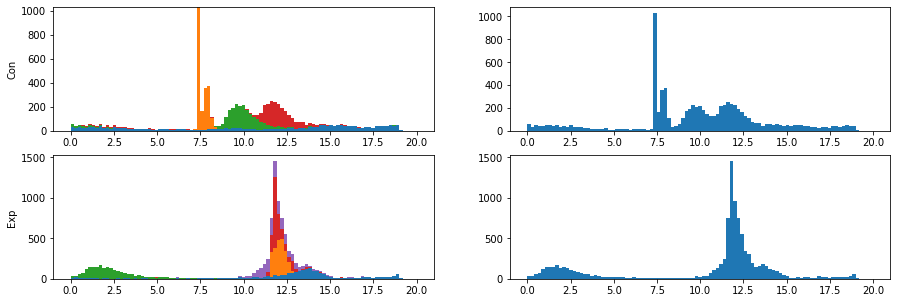

In [108]:
con_tau_array = np.array([this_trace["tau"] for this_trace in con_traces])
exp_tau_array = np.array([this_trace["tau"] for this_trace in exp_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].hist(con_tau_array.T, bins, stacked = 'true');
ax[0,1].hist(con_tau_array.flatten(), bins, stacked = 'true');
ax[1,0].hist(exp_tau_array.T, bins, stacked = 'true');
ax[1,1].hist(exp_tau_array.flatten(), bins, stacked = 'true');

ax[0,0].set_ylabel('Con');
ax[1,0].set_ylabel('Exp');

In [90]:
con_ppcs = [pm.sample_posterior_predictive(this_trace, samples=100, model=model) for this_trace in con_traces]
exp_ppcs = [pm.sample_posterior_predictive(this_trace, samples=100, model=model) for this_trace in exp_traces]

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 127.46it/s]


In [91]:
con_obs_ppc_array = np.array([this_ppc["obs"] for this_ppc in con_ppcs])
exp_obs_ppc_array = np.array([this_ppc["obs"] for this_ppc in exp_ppcs])

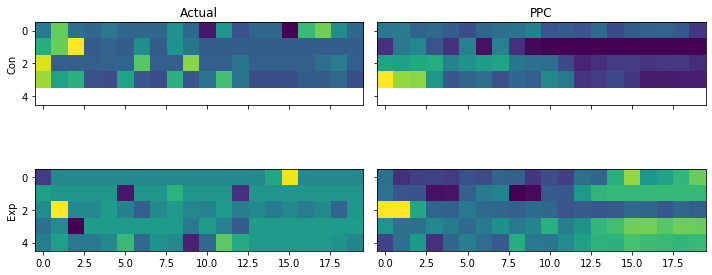

In [92]:
fig,ax=plt.subplots(2,2, sharex=True, sharey=True, figsize = (10,5));
ax[0,0].imshow(con_data_mat)
ax[0,1].imshow(np.mean(con_obs_ppc_array,axis=1))
ax[1,0].imshow(exp_data_mat)
ax[1,1].imshow(np.mean(exp_obs_ppc_array,axis=1))
ax[0,0].set_ylabel('Con')
ax[1,0].set_ylabel('Exp')
ax[0,0].set_title('Actual')
ax[0,1].set_title('PPC')
plt.tight_layout()

In [93]:
con_mean_tau = np.mean(con_tau_array,axis=-1)
con_sd_tau = np.std(con_tau_array,axis=-1)
exp_mean_tau = np.mean(exp_tau_array,axis=-1)
exp_sd_tau = np.std(exp_tau_array,axis=-1)

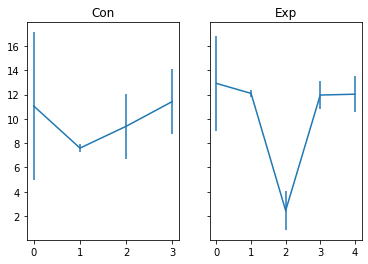

In [94]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].errorbar(x = np.arange(len(con_mean_tau)), y = con_mean_tau, yerr = con_sd_tau);
ax[1].errorbar(x = np.arange(len(exp_mean_tau)), y = exp_mean_tau, yerr = exp_sd_tau);
ax[0].set_title('Con');
ax[1].set_title('Exp');